# Exploratory Data Analysis - 311 Data
1. Ten Most Common Service Requests
2. Busiest Divisions
3. Distribution of Calls vs. Open311 App vs. Self Service (SS) reporting on the web
4. Average Number of Days Cases Are Open - Per Division
5. Divisions with the largest change in volume or number of days open from 2016 to 2017
6. Busiest Months/Dates for opening cases and closing cases
7. Complaint type volume per open date or per closed date 
8. Case types that collect location
9. Map distribution of cases (by type?)
10.


In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import folium
from folium import plugins
import json
import geojson

In [2]:
# Read the csv file of cleaned data.
df = pd.read_csv('311_clean.csv', index_col=[0,1], parse_dates = ['Date', 'closed_date', 'open_day'])
df.head()

status         closed_date  days_open           reason  \
Date       Time                                                               
2016-01-01 00:10:35       0 2016-01-02 12:03:41        2.0  Traffic Control   
           07:50:34       0 2016-01-02 09:08:54        2.0  Traffic Control   
           08:46:35       0 2016-02-08 11:28:20       39.0       Snow & Ice   
           09:35:17       0 2016-01-04 09:30:00        3.0  Traffic Control   
           10:00:34       0 2016-01-02 09:37:55        1.0  Traffic Control   

                                    subject                        title  \
Date       Time                                                            
2016-01-01 00:10:35  Vehicles and Commuting  Abandoned Vehicle - Open311   
           07:50:34  Vehicles and Commuting  Parking Violation - Open311   
           08:46:35               Sidewalks   Sidewalk Snow and Ice - SS   
           09:35:17  Vehicles and Commuting  Parking Violation Complaint   
           10:00:34  Vehicles and Commuting  Parking Violation - Open311   

                     object_id       x_coord       y_coord     x_geom  \
Date       Time                                                         
2016-01-01 00:10:35       2196 -1.038160e+07  5.613667e+06 -93.259481   
           07:50:34      29550 -1.038520e+07  5.616158e+06 -93.291802   
           08:46:35      19633 -1.037889e+07  5.625311e+06 -93.235196   
           09:35:17      19634 -1.038501e+07  5.604598e+06 -93.290172   
           10:00:34       2197 -1.038350e+07  5.615948e+06 -93.276582   

                        ...      opened_month   open_day  open_time  \
Date       Time         ...                                           
2016-01-01 00:10:35     ...                 1 2016-01-01   00:10:35   
           07:50:34     ...                 1 2016-01-01   07:50:34   
           08:46:35     ...                 1 2016-01-01   08:46:35   
           09:35:17     ...                 1 2016-01-01   09:35:17   
           10:00:34     ...                 1 2016-01-01   10:00:34   

                    closed_year closed_month  max_temp  min_temp  \
Date       Time                                                    
2016-01-01 00:10:35      2016.0          1.0        30        15   
           07:50:34      2016.0          1.0        30        15   
           08:46:35      2016.0          2.0        30        15   
           09:35:17      2016.0          1.0        30        15   
           10:00:34      2016.0          1.0        30        15   

                     precipitation   snow  snow_depth  
Date       Time                                        
2016-01-01 00:10:35          0.005  0.005         4.0  
           07:50:34          0.005  0.005         4.0  
           08:46:35          0.005  0.005         4.0  
           09:35:17          0.005  0.005         4.0  
           10:00:34          0.005  0.005         4.0  

[5 rows x 22 columns]

## Ten Most Common Service Requests
The following are the most **common requests**
- Abandoned Vehicle
- Parking Violiation
- Exterior Nuisance Complaint
- Animal Complaint - Livability
- Graffiti complaint / reporting

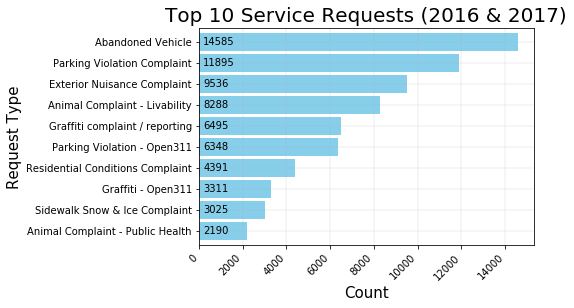

In [3]:
# Plot top 10 complaints by title
top_titles = df.groupby('title')['title'].count().sort_values(
                        ascending=False).head(10).sort_values()
_ = top_titles.plot.barh(color="skyblue", width = .85)

# Include numeric counts on each bar
for i, v in enumerate(top_titles):
    plt.text(200, i, str(v), va = 'center', color='black') #, fontweight='bold')

_ = plt.title('Top 10 Service Requests (2016 & 2017)', fontsize=20)
_ = plt.xlabel('Count', fontsize=15)
_ = plt.ylabel('Request Type', fontsize=15)
_ = plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
_ = plt.grid(linewidth=.2)
plt.show()

## Busiest Departments
The following are the most **active departments**
- Vehicles and Commuting
- Property
- Streets
- Public Safety
- Animal Related
- Sidewalks

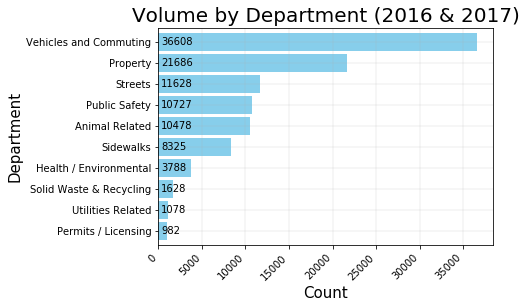

In [4]:
# Plot top 10 complaints by subject
top_depts = df.groupby('subject')['subject'].count().sort_values(
                        ascending=False).head(10).sort_values()
_ = top_depts.plot.barh(color= "skyblue", width = .85)

# Include numeric counts on each bar
for i, v in enumerate(top_depts):
    plt.text(300, i, str(v), va = 'center', color='black')

_ = plt.title('Volume by Department (2016 & 2017)', fontsize=20)
_ = plt.xlabel('Count', fontsize=15)
_ = plt.ylabel('Department', fontsize=15)
_ = plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
_ = plt.grid(linewidth=.2)
plt.show()

## Complaints By Reporting Platform (Phone, App, Online)
Complaints can be reported via 3 platforms: Calls, Open311 App, and Self Service (SS) online.  
*(Stacked graph by platform by month)*

- **App Reporting is Effective in Reducing Phone Staff** by including high volume topics that don't require immediate service.
- **Website Use Follows Overall Volume Patterns** with Exterior Nuisance complaints in the summer and Sidewalk Snow and Ice complaints in the winter.

In [5]:
#Divide calls by reporting platform (Phone, App, Web)
open311_app = df[df.title.str.contains("Open311")]
ss_web = df[df.title.str.contains("- SS") | df.title.str.contains("- Self")]
phone = df[~df.title.str.contains("- SS") & ~df.title.str.contains("- Self") & ~df.title.str.contains("Open311")]

#ss_web.title.value_counts()
# 'Sidewalk Snow and Ice', 'Exterior Nuisance Complaint', 'Unpermitted Work' 
#open311_app.title.value_counts()

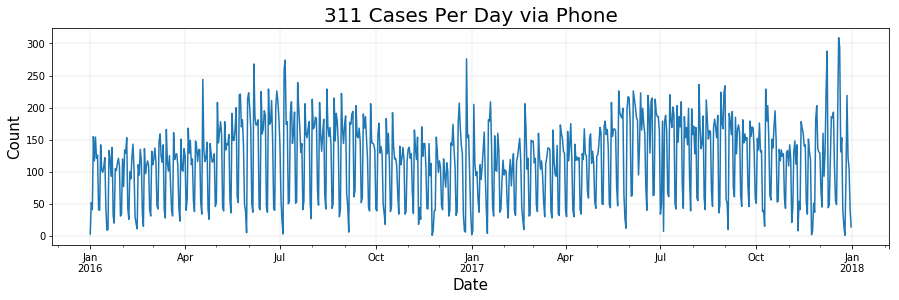

In [6]:
# Time series for requests received via phone.
phone.groupby('Date')['subject'].count().plot(figsize = (15,4))

plt.title('311 Cases Per Day via Phone', fontsize=20)
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.grid(linewidth=.2)
plt.show()

### App Reporting is Effective in Reducing Phone Staffing
The top 4 App-reported complaints are among the highest volume topics overall. Furthermore, around 1/3 of the Parking Violations and Graffiti complaints are reported through the 311 app. 

With an eye to reducing phone staff, the App topics were well chosen. All are high volume service drivers, while none require immediate assistance (as Animal Related complaints might). This seems to be an efficient use of technology.

In [7]:
open311_app.title.value_counts().head(10)

Parking Violation - Open311                 6348
Graffiti - Open311                          3311
Abandoned Vehicle - Open311                 2003
Sidewalk Snow Ice - Open311                 1340
Street Light Trouble - Open311              1150
Pothole - Open311                           1104
Sidewalk Structural - Open311                840
Traffic Signal Trouble - Open311             456
Traffic Sign Repair - Open311                425
Solid Waste Overflowing Litter - Open311     360
Name: title, dtype: int64

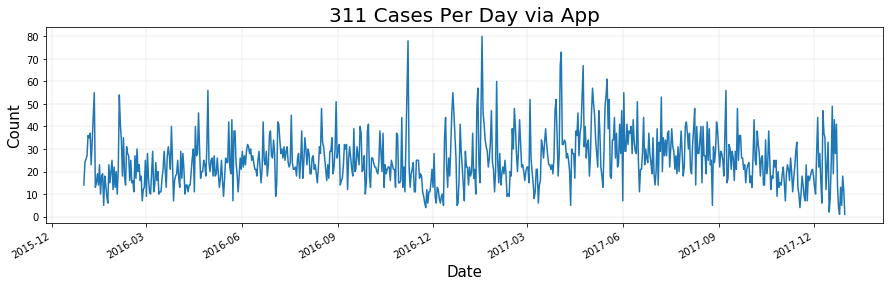

In [8]:
# Time series for requests received via open311_app.

open311_app.groupby('Date')['subject'].count().plot(figsize = (15,4))
plt.title('311 Cases Per Day via App', fontsize=20)
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.grid(linewidth=.2)
plt.show()

### Website Use Follows Typical Volume Patterns for Exterior Nuisance and Sidewalk Snow and Ice complaints
Complaints reported on the website's Self-Service portal show sudden peaks December - February which are consistent with Sidewalk Snow and Ice accumulation.  

Throughout the summer months, Exterior Nuisance complaints increase. Once the snow melts, temperature rise, and students are out of school, it's time to enjoy being outside. Although noise complaints were reported on the website during the summer of 2016, far fewer were reported in 2017.

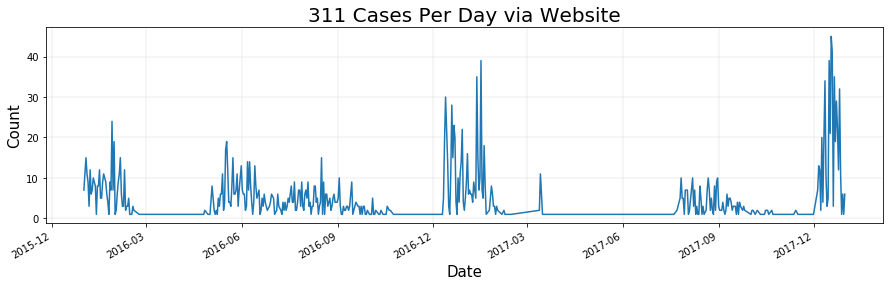

In [9]:
# Time series for requests received via web (Self-Service).
ss_web.groupby('Date')['subject'].count().plot(figsize = (15,4))

plt.title('311 Cases Per Day via Website', fontsize=20)
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.grid(linewidth=.2)
plt.show()

In [10]:
#Isolate phone calls that correspond to topics reported on the web.
web_as_calls = phone[(phone.title.str.contains("Sidewalk Snow") 
                      | phone.title.str.contains("Exterior Nuisance Complaint") 
                      | phone.title.str.contains("Unpermitted Work"))]

#web_as_calls = phone[(phone.title.str.contains("Sidewalk Snow") | phone.title.str.contains("Exterior Nuisance Complaint") | phone.title.str.contains("Unpermitted Work")) & ~phone.title.str.contains("RHOD")]

print('Web: ', ss_web.title.value_counts(), '\n')
print('Phone: ', web_as_calls.title.value_counts())


Web:  Sidewalk Snow and Ice - SS          1333
Exterior Nuisance - Self Service     971
Unpermitted Work - Self Service       42
Name: title, dtype: int64 

Phone:  Exterior Nuisance Complaint         9536
Sidewalk Snow & Ice Complaint       3025
Unpermitted Work                     682
RHOD Exterior Nuisance Complaint     595
Name: title, dtype: int64


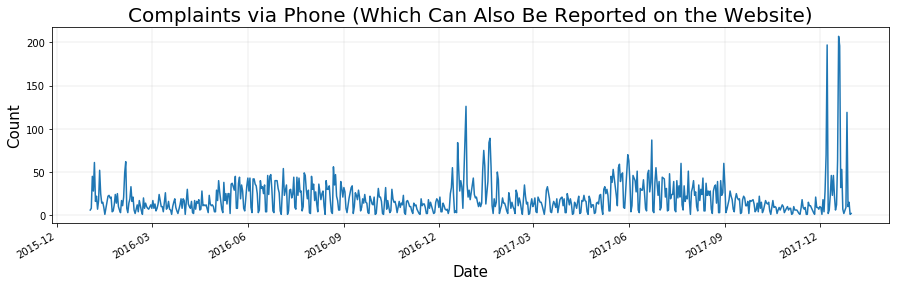

In [11]:
# Time series for phoned complaints also reported via the web (Self-Service).

web_as_calls.groupby('Date')['subject'].count().plot(figsize = (15,4))
plt.title('Complaints via Phone (Which Can Also Be Reported on the Website)', fontsize=20)
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.grid(linewidth=.2)
plt.show()


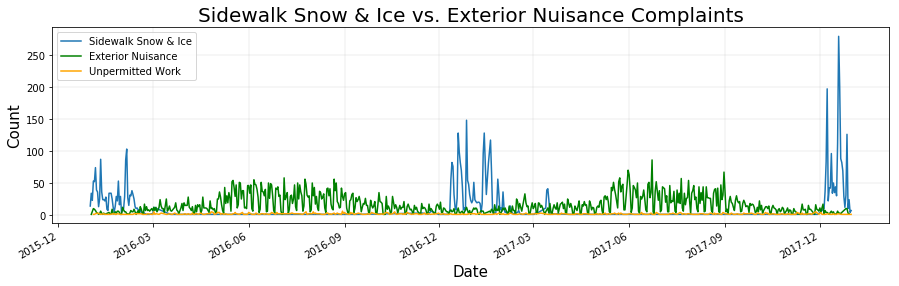

In [12]:
# Plot Sidewalk Snow & Ice complaints
sidewalk_ice = df[df.title.str.contains("Sidewalk Snow")]
sidewalk_ice.groupby('Date')['subject'].count().plot(
    figsize = (15,4), label = 'Sidewalk Snow & Ice')

# Plot Exterior Nuisance complaints
ext_nuisance = df[df.title.str.contains("Exterior Nuisance")]
ext_nuisance.groupby('Date')['subject'].count().plot(
    figsize = (15,4), color = 'g', label = 'Exterior Nuisance')

unpermitted_work = df[df.title.str.contains("Unpermitted Work")]
unpermitted_work.groupby('Date')['subject'].count().plot(
    figsize = (15,4), color = 'orange', label = 'Unpermitted Work')

plt.legend()
plt.title('Sidewalk Snow & Ice vs. Exterior Nuisance Complaints', fontsize=20)
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.grid(linewidth=.2)
plt.show()

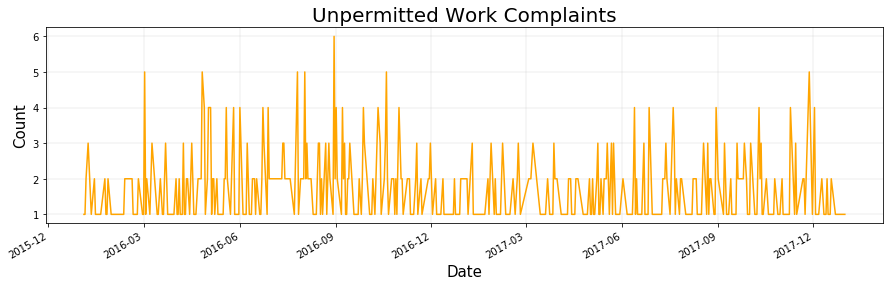

In [13]:
# Zoom in on Unpermitted Work complaints
unpermitted_work = df[df.title.str.contains("Unpermitted Work")]
unpermitted_work.groupby('Date')['subject'].count().plot(figsize = (15,4), color = 'orange')
plt.title('Unpermitted Work Complaints', fontsize=20)
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.grid(linewidth=.2)
plt.show()

## How Many Days Does Take to Close a Case?
On average, cases were closed within 3 days. Within 7 days (a week), 75% of cases were closed. That said, the distribution is skewed with many cases left open for over 100 days.

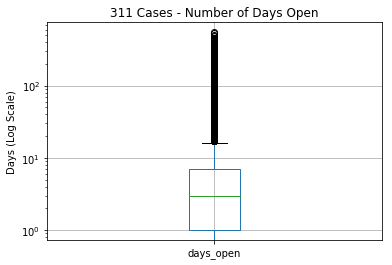

In [14]:
# View box plot of number of days open, to visually inspect outliers
df.boxplot(column='days_open')
plt.yscale('log')
plt.title('311 Cases - Number of Days Open')
plt.ylabel('Days (Log Scale)')
plt.show()

## Average Number of Days Cases Are Open - Per Division
* Every subject has a wide range of days until a case is closed. With data points spread from 0 to 549, the y-axis was scaled with the log function. This makes higher data points more visible. However, the 25th percentile is 0 for more than half the subjects, and isn't visible as it lies on the x-axis.
* The 25th to 75th percentile box for Animal Related cases lies entirely at 0. Only the non-zero outliers are visible. This subject has the most consistent close time, and has the 2nd shortest spread. Permits/Licensing has a slightly shorter overall spread.
* There aren't strong patterns correlating mean, spread, and density. 

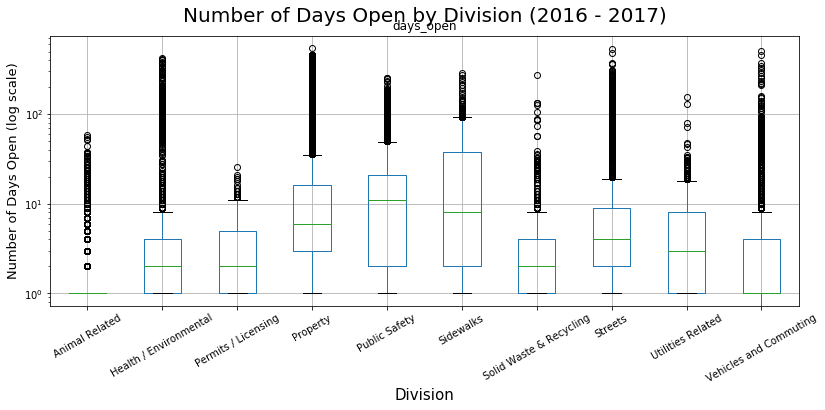

In [15]:
# Visualize boxplots, by subject, of number of days each case is open.
fig, ax = plt.subplots(figsize=(13,5))
#plt.suptitle('Number of Days Open by Division (2016 - 2017)', fontsize=20)
df.boxplot(column=['days_open'], by='subject', ax=ax, rot=30)
plt.yscale('log')
#plt.title('Number of Days Open by Division (2016 - 2017)', fontsize=20)
plt.xlabel('Division', fontsize=15)
plt.ylabel('Number of Days Open (log scale)', fontsize=13)
#plt.title('Number of Days Open by Division', fontsize=20)
plt.suptitle('Number of Days Open by Division (2016 - 2017)', fontsize=20)

plt.show()

## A large group of calls were closed on 2018-01-29, 2017-03-31

### Residential Conditions Complaints 
A cluster of more than 250 Residential Conditions Complaints were all closed at the end of October, 2017. Identical x- y- coordinates indicate they were complaints about the same building.

In [16]:
top_close = df.closed_date.value_counts(dropna=False)[:11]
top_close

NaT                    603
2018-01-29 07:41:25    100
2018-01-29 07:39:05    100
2017-03-31 08:45:18     95
2018-01-29 07:36:39     95
2018-01-29 08:26:09     91
2017-03-31 13:45:55     91
2017-10-31 12:34:48     84
2017-03-31 13:47:49     68
2018-01-29 07:46:29     64
2018-01-29 08:27:21     63
Name: closed_date, dtype: int64

In [17]:
for index in top_close.index:
    reason = df.loc[df.closed_date == index].reason.value_counts()
    print(index, ": ", reason)

NaT :  Series([], Name: reason, dtype: int64)
2018-01-29 07:41:25 :  Snow & Ice    100
Name: reason, dtype: int64
2018-01-29 07:39:05 :  Snow & Ice    100
Name: reason, dtype: int64
2017-03-31 08:45:18 :  Snow & Ice    95
Name: reason, dtype: int64
2018-01-29 07:36:39 :  Snow & Ice    95
Name: reason, dtype: int64
2018-01-29 08:26:09 :  Snow & Ice    91
Name: reason, dtype: int64
2017-03-31 13:45:55 :  Snow & Ice    91
Name: reason, dtype: int64
2017-10-31 12:34:48 :  Private Property    84
Name: reason, dtype: int64
2017-03-31 13:47:49 :  Snow & Ice    68
Name: reason, dtype: int64
2018-01-29 07:46:29 :  Snow & Ice    64
Name: reason, dtype: int64
2018-01-29 08:27:21 :  Snow & Ice    63
Name: reason, dtype: int64


### Import Neighborhood Shape File
http://opendata.minneapolismn.gov/datasets/neighborhoods
* Neighborhoods.shp

In [18]:
# read in neighborhoods shapefile
hoods = gpd.read_file(r"Neighborhoods/Neighborhoods.shp")
hoods.head(3)

,OBJECTID,INT_REFNO,PREFIX,UDI,SYMBOL_NAM,BDNAME,BDNUM,TEXT_NBR,Shape__Are,Shape__Len,geometry
0,1,-2144139700,REFNO,23103.00,WARDAREA,Victory,3,03,0.000202,0.068721,"POLYGON ((-93.3193815366222 45.042016303131, -..."
1,2,0,REFNO,23108.00,WARDAREA,Humboldt Industrial Area,8,08,0.000081,0.049060,"POLYGON ((-93.3193860506565 45.0421783244357, ..."
2,3,-2144133700,REFNO,23163.00,WARDAREA,Howe,63,63,0.000314,0.082525,"POLYGON ((-93.2010422053324 44.941551562735, -..."


In [19]:
#df.loc[(df.closed_date == '2017-10-31 12:34:48') & (df.title == 'Residential Conditions Complaint')][].head()

res_cluster = df.loc[(df.closed_year == 2017) & (df.closed_month == 10.0) & 
                     (df.title == 'Residential Conditions Complaint')][
                      ['closed_date', 'object_id', 'x_coord', 'y_coord', 'x_geom', 'y_geom']]

res_cluster.tail()

closed_date  object_id  x_coord  y_coord  \
Date       Time                                                        
2017-10-27 06:49:12 2017-10-31 03:23:22      50461      0.0      0.0   
           09:51:52 2017-10-30 03:41:19       3972      0.0      0.0   
2017-10-28 11:16:36 2017-10-30 10:35:04       6267      0.0      0.0   
2017-10-30 11:00:28 2017-10-31 03:46:25       6319      0.0      0.0   
2017-10-31 04:55:56 2017-10-31 06:58:38      46588      0.0      0.0   

                           x_geom        y_geom  
Date       Time                                  
2017-10-27 06:49:12  2.544444e-14 -1.280796e-14  
           09:51:52  2.544444e-14 -1.280796e-14  
2017-10-28 11:16:36  2.544444e-14 -1.280796e-14  
2017-10-30 11:00:28  2.544444e-14 -1.280796e-14  
2017-10-31 04:55:56  2.544444e-14 -1.280796e-14

In [20]:
res_cluster.x_coord.value_counts()

0.0    266
Name: x_coord, dtype: int64

In [21]:
res_cluster.x_geom.value_counts()

2.544444e-14    254
0.000000e+00     12
Name: x_geom, dtype: int64